In [31]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from scipy.stats import gamma # gamma(a, begin_time, b)
from random import random as rand
from math import log
from skimage.io import imread,imshow
from skimage.transform import resize
from functools import reduce
from operator import add
from itertools import *

from numpy import maximum as m
import numpy as np
from functools import reduce
from operator import add
from support import *
import support

import warnings

warnings.filterwarnings("ignore")

import sys

sys.setrecursionlimit(4000)

matplotlib.rcParams["figure.figsize"] = 9., 6.



In [2]:
X, y = generate_data()
support.demonstrate_data(X, y)

NameError: name 'demonstrate_data' is not defined

<html><h4>Andrew Henrichsen<br>Joseph Szendre<br>Estimating Demand Functions using NHPPs<br></h4></html>
"Supply chain is the practice of predicting the future and bending it to your will." - Renaldo

In every marketplace, businesses and consumers make decisions about price, quantities and timing of purchases and sales in a melee of rapid-fire decision making and half-baked assumptions. Rarely do any decisions *not* involve some consideration of predicting the future: "What will the price be in a week? If so, should I buy now?" or "What price do I need to set in order to sell all of my inventory?" are common questions, and answers to them are not cheap. Predicting the future is hard, predicting it accurately, even more so. However, many decisions need to be based off of events that have not yet happened, which creates quite a conundrum. Especially where business is concerned, inaccuracy can cost billions of dollars.

Predictive analytics is the field of taking data from the past and attempting to predict behavior in the future or under novel conditions. It comprises the methods used by a data analyst to pull back the curtains of the future and peek through at what might be expected.

For our project, we are answering the question "What price should I charge in order to get the best return?" for the case of online sales. Generally, this answer is different for the short and the long term, and our method lends itself well to providing both answers. 

The price at which all of the inventory is sold and there is no shortage is called the *market clearing price*. It is the intersection of the supply and demand curves (For a description of what these mean, we refer you to an introductory book on economics.). In theory, the optimal price to sell goods is this price, the price at which the last item is purchased by the last customer who wanted to buy. However, finding this price requires knowing both the supply and demand curves, which is a major difficulty.

Supply and demand curves are abstractly representative of the workings of a market. However, there is no parametric equation for the curves for any product handed out in business school. Indeed, one of the most nervewracking and time consuming parts of being a business owner is guessing at these curves, as they determine the results of many actions a business might take. If a business owner knows the shape of the demand curve, he or she can easily calculate exactly what price to charge in order to sell all of his or her inventory.

Supply curves are easier for a business owner to predict, though not a trivial task. Business owners know the cost to expand his or her enterprise, the price at which additional workers are hired, the salaries and productivity of their individual workers, and has access to a great deal of data that allows him or her to manage the business. Demand curves are much harder to understand and predict, since the apparatus of decision making is outside the owner's control, and is a very chaotic system containing a myriad of sub-systems and complex interactions all extrapolated from individual decisions of how much to buy.

<h4>Modelling Demand</h4>
Demand as a function of price and time is frequently modelled using a log linear function when the various sellers are not in a perfectly competitive position. This means that there is a half-life like change in price at which demand halves.

In the literature when time dependence is not considered, demand is modelled as a * e^(b - w'p) with units quantity / time unit (hour). Here p is a vector that contains the current price and any other features that could influence price besides time, w is the weights given to each, b is a bias term, and a scales the function.

In order to predict demand curves, we decided that we will define demand to be the rate of items being purchased at a given price. Since the particular decisions of separate individuals to buy are fairly independent in the short term and the timing of the decisions can be modelled as a random variable, a poisson process is particularly appropriate to model demand. However, since the average rate may change over time and vary in response to a host of factors, we use a non-homogenous poisson process to model demand. A non homogeneous poisson process (NHPP), is one where lambda (the descriptor of the average rate at which events happen) is a function of one or more variables. Note: the class of problems describing purchases over time is called arrival process. 

<h4>Incorporating NHPPs into modelling demand</h4>
NHPPs yield very expressive measures of arrival processes. By sampling repeatedly from our process, we can take the mean of our samples, and use that as our estimate for the cumulative intensity function, or the number of purchases made in the time interval,  i.e. the demand over time.

<h4>Data Collection</h4>
&nbsp;&nbsp;&nbsp;&nbsp;Data on arrival and purchase times, prices, etc is highly proprietary, and generally requires more than just a nondisclosure agreement to access. Given this limitation, we used the process given in "Learning in Short-Time Horizons with Measurable Costs" [Mullen, 2006] to predict the expected value of demand as a log linear function of time.  Using these functions that are standard in the literature, we have generated a significant quantity of data for testing, training, and refining our model.

***Modelling arrival times using Nonhomogeneous Poisson Processes, From First Principles***

We now explain the concept and capabilities we have to analyze time series data using nonhomogeneous poisson processes (NHPPs) starting with piecewise composition of poisson processes.

We assume that the rate function is constant over each hour and so the number of arrivals in each hour can be modelled using the Poisson discrete process with no loss of expressability.


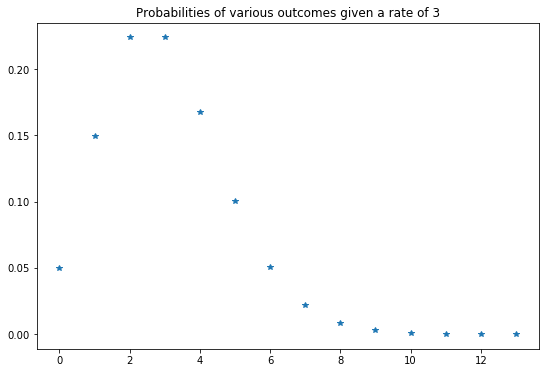

In [32]:
from matplotlib import pyplot as plt
import numpy as np; np.set_printoptions(2)
from scipy.stats import poisson
from scipy.special import factorial

number_of_time_units = 1
rate = 5

# Scale the rate parameter by the length of time
def gen_probabilities_for_outcomes(rate, length_of_time=1., n=10):
    rate *= length_of_time
    res2 = poisson(rate).pmf(np.arange(n))
    res2[res2 <= 0] = 0 # Unforunately -0.0 is a valid floating point number
    return res2

n = 14
rate = 3
test_vector = gen_probabilities_for_outcomes(rate, 1, n)
plt.title("Probabilities of various outcomes given a rate of " + str(rate))
plt.plot(np.arange(n), test_vector, "*")
plt.show()

***Achtung!***
Note that for this distribution the probability with rate 3 the probability that a 3 is observed is only 0.224

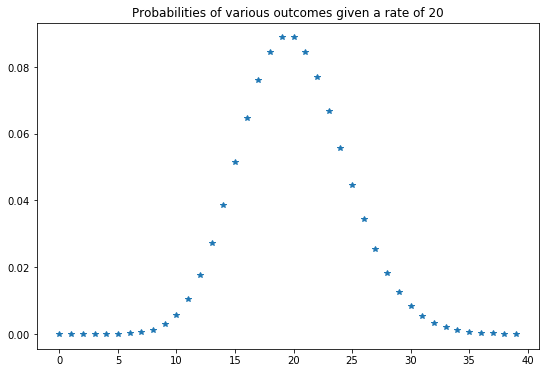

In [33]:
rate = 20
n = 40
test_vector = gen_probabilities_for_outcomes(rate, 1, n)
assert  test_vector.sum() > .99 and np.min(test_vector) >= 0, "Not a probability vector:\n" + str(test_vector) + "\n" + str(test_vector.sum())
plt.title("Probabilities of various outcomes given a rate of " + str(rate))
plt.plot(np.arange(n), test_vector, "*")
plt.show()


Note that the Maximum Likelihood Estimate (MLE) of the rate parameter is the number of occurrences in a time interval.

***Modelling Intra-Weekday Demand, hour by hour*** 

Suppose that we wish to estimate how frequent customers purchase items during different times of the day, to predict future demand. Assuming that distribution is poisson but not homogeneous lets us divide time intervals into bins and estimate the aggregate rate for those intervals.

We do this by dividing the work day into 24 time intervals (hours) and count how many arrivals happened within each. Those counts represent our best estimate for the rate function for each hour.

In [34]:
# Try to model arrivals by estimating each hour separately
discrete_rates = np.array([8,6,4,3,5,7,8,8]) # the rates for each time interval
aggregate_rate = sum(discrete_rates) # the aggregate rate for the work day is 51

# We now simulate a day using those rates
def realize_process(discrete_rates):
    # This just works...
    result = [np.arange(r*10)[np.random.random() < np.cumsum(gen_probabilities_for_outcomes(r, 1, r*10))][0] for r in discrete_rates]
    return np.array(result)
        
print("Notice the varation (in ratios) between the actual counts observed " + \
   "and the expected counts. The ratios are for the hours 9-10, 10-11, 11-12, etc...")

def realize_n_proccesses(discrete_rates, n):
    return np.array([realize_process(discrete_rates) for _ in range(n)])

n, k = 5, 1
realizations = realize_n_proccesses(discrete_rates,n)
for row in realizations:
    print("Simulation", k, row/discrete_rates); k+=1

Notice the varation (in ratios) between the actual counts observed and the expected counts. The ratios are for the hours 9-10, 10-11, 11-12, etc...
Simulation 1 [ 1.75  0.83  0.5   1.    1.4   1.    0.88  0.88]
Simulation 2 [ 1.75  0.5   1.    1.33  2.2   1.    1.25  0.5 ]
Simulation 3 [ 1.25  1.33  0.75  0.67  1.4   0.86  1.38  1.  ]
Simulation 4 [ 1.    1.5   0.75  0.33  0.8   0.86  0.88  0.62]
Simulation 5 [ 0.12  1.17  2.25  1.33  2.    0.57  1.    0.88]


***Standard Errors of these estimates as a percentage***

Rows denote different days, columns denote which time interval the estimate is in.

In [35]:
relative_errors = (1. * realizations - discrete_rates) / discrete_rates # Uses Array Broadcasting unique to numpy
print("Rates from which each realization is drawn: ", discrete_rates)
print(relative_errors)

Rates from which each realization is drawn:  [8 6 4 3 5 7 8 8]
[[ 0.75 -0.17 -0.5   0.    0.4   0.   -0.12 -0.12]
 [ 0.75 -0.5   0.    0.33  1.2   0.    0.25 -0.5 ]
 [ 0.25  0.33 -0.25 -0.33  0.4  -0.14  0.38  0.  ]
 [ 0.    0.5  -0.25 -0.67 -0.2  -0.14 -0.12 -0.38]
 [-0.88  0.17  1.25  0.33  1.   -0.43  0.   -0.12]]


***Any one of these rows could be the relative error per hour if we only use one day***

Now we observe that the relative errors go down as the rate goes up. 

In [36]:
# Use a poisson process with 20 times the rate parameter
discrete_rates2 = 20*discrete_rates

realizations2 = realize_n_proccesses(discrete_rates2,n)

standard_deviations_away2 = (realizations2 - discrete_rates2) / np.sqrt(discrete_rates2) # Uses Array Broadcasting unique to numpy
relative_errors2 = 100*(realizations2 - discrete_rates2) / discrete_rates2 # Uses Array Broadcasting unique to numpy
print("New rates: " + str(discrete_rates2))
print("Standard Deviations away from the true value:",
      "\nNote that this does not imply that it's normally distributed\n",standard_deviations_away2)
print("\nRelative error of each estimate as a percentage:\n", relative_errors2)


New rates: [160 120  80  60 100 140 160 160]
Standard Deviations away from the true value: 
Note that this does not imply that it's normally distributed
 [[ 1.11  0.37 -1.01  1.16  0.9   0.68 -1.19  0.32]
 [-2.13 -0.55  0.34  0.65 -0.8   0.93 -1.82  0.16]
 [ 0.79 -1.83 -2.01  0.    0.1  -0.68  0.95 -0.79]
 [ 2.13 -1.83  0.34 -0.77  0.3   0.34  0.   -0.63]
 [ 0.08  0.   -1.12 -0.26 -1.4   0.17 -1.26  1.03]]

Relative error of each estimate as a percentage:
 [[  8.75   3.33 -11.25  15.     9.     5.71  -9.38   2.5 ]
 [-16.88  -5.     3.75   8.33  -8.     7.86 -14.38   1.25]
 [  6.25 -16.67 -22.5    0.     1.    -5.71   7.5   -6.25]
 [ 16.88 -16.67   3.75 -10.     3.     2.86   0.    -5.  ]
 [  0.62   0.   -12.5   -3.33 -14.     1.43 -10.     8.12]]


***Increased Accuracy Observed with increasing rates, length of time intervals***

As you can see here, as the rate was increased by a factor of 20, the relative error decreased significantly (can be expected to be the inverse square of 20). Equivalently, when we extend the length of the time intervals, we observe the same decrease of relative error. This, as is expected, means that the more data we have, the better our estimate of the demand curve is.

However, there is a trade off between the size of time intervals and the accuracy of estimates. If the size of the time intervals are larger, the relative error goes down, but there is less information to exploit for a dynamic pricing engine. Thus, research suggests that when using discreet estimates for the rate function the bin width should decrease with the amount of data collected.

***Estimating a interval rates by overlapping data***

Only using one day is too narrow a focus, and with small amounts of data the ideal time interval would be the entire day, making our model much less useful.

To overcome this, we can create estimates for the rate function by overlapping data from different days, since from the research and real world observations of Amazon's data, most days have a very similar rate function.


***Stacking multiple days***

If we stack multiple simulations on top of one another we get a higher accuracy estimate of small time intervals, since the increased number of instances causes random errors to relatively cancel out, leaving us with a lower relative error.

The way we do this is to add up the arrivals in each interval across the number of days and then divide by the number of days.

Here we show that by using stacking 10 days worth of simulated data, we can ***expect the same accuracy (small distribution of relative errors)*** as when multiplying the rates by 10.

Note that for any continous function, the average over a time interval is still well defined, thus this analysis carries over to NHPPs.


In [37]:
def get_average_rate_n_simulations(discrete_rates, n_simulations):
    result = np.sum(realize_n_proccesses(discrete_rates,n_simulations), axis=0) / n_simulations
    return result

estimate = get_average_rate_n_simulations(discrete_rates, 20)
print("Notice that each time we stack 20 different simulations we get a much more accurate estimations for each hour")
print("average of 20 simulated work days", estimate)
print("These are are to estimate", 1.*discrete_rates)

relative_errors3 = 100*(estimate-discrete_rates)/discrete_rates
print("\nRelative error by hour of day:", relative_errors3)


print("\nAverage magnitude of the relative errors")
print("  One sample at original rate function:", np.abs(relative_errors).mean())
print("  Multiplying the rate function by 20:",np.abs(relative_errors2).mean())
print("  Stacking 20 samples of the same rate function:", np.abs(relative_errors3).mean())


Notice that each time we stack 20 different simulations we get a much more accurate estimations for each hour
average of 20 simulated work days [ 9.2   5.6   4.25  2.8   4.7   5.65  8.5   7.65]
These are are to estimate [ 8.  6.  4.  3.  5.  7.  8.  8.]

Relative error by hour of day: [ 15.    -6.67   6.25  -6.67  -6.   -19.29   6.25  -4.37]

Average magnitude of the relative errors
  One sample at original rate function: 0.35306547619
  Multiplying the rate function by 20: 7.61011904762
  Stacking 20 samples of the same rate function: 8.81175595238


<h4>Modelling Using the Continuous Arrival Processes instead of Discrete Distributions</h4>

To take our model the final step, instead of using estimates for the number of arrivals for a given hour with a single parameter, we model the instantaneous average as a continuous function of time. In order to do this, we record the precise time that an arrival happens, instead of the total number of arrivals within a certain period. This is much more useful, since it will actually give us an estimate to the demand curve instead of just an estimate of its value every hour.

If the rate parameter is a constant, then the algorithm performed above is wholly sufficient. However, as is more likely, if the rate of purchases varies continuously over time, the arrivals that are generated by that distribution will better be modelled by the NHPP distribution. Due to the increased complexity of modelling the distribution over a certain arrival time, we use the algorithm cited above [Mullen, 2006], among others, to produce arrival times.

<h4>Generating the Data</h4>
Like MCMC methods, this algorithm takes in a process that strictly dominates the demand curve, then thins it according to the ratios between the two processes' rates for a certain point. The algorithm proceeds forward from 0 to T, and if a point is not accepted, the new candidate is calculated forward from the rejected point. Pseudocode for the algorithm is given below:

<h4>Simulate NHPP, lambda(t), l_sup = sup (lambda(t))</h4>
1. input: rate, T (number of hours, days, etc... to simulate at constant rate)
2. current_time = 0
3. times = []
4. u0, u1 = U(0,1), U(0,1) # both ~ Uniform[0,1]
5. current_time = current_time - log(u1) / rate
6. if current_time < T and
7. &nbsp;&nbsp;&nbsp;if U(0,1) < lambda(t) / l_sup:
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;append (current_time + interarrival_time) to the list times
9. &nbsp;&nbsp;&nbsp;&nbsp;return to 4
9. output times

As modelled below.

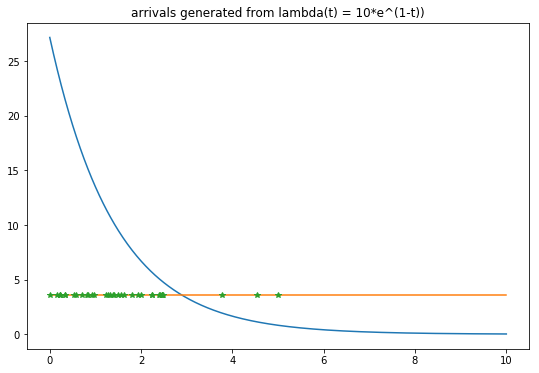

In [38]:
def sample(intensity_fct, a, b, sup_lambda):
    x_ = a
    arrivals = []
    while x_ < b:
        x_ += -np.log(np.random.random()) / sup_lambda
        if np.random.random() < intensity_fct(x_) / sup_lambda:
            arrivals.append(x_)
    return arrivals[:-1]

demonstrate_thinning()

**Novel Estimator of NHPP rate functions**

There are a few differences between our approach and those of the tens of articles that were reviewed for this lab. It seems to be standard practice to estimate the cumulative rate function, which is the integral of the rate function. However, we found that estimating the cumulative rate function was difficult to visualize.

We estimate the instantaneous rate function lambda by using the optimal kernel density function (3/4)*(1-((x-c)/r)^2)/4.

The way that we calculate the radius for a given set of arrivals is by the following: r = (b-a) / sqrt(number_arrivals). This way the size of the kernel function varies proportionately to the standard deviation of the standard deviation of the interarrival times. This way if a rate function is scaled, the radius will scale proportionate to the variation in interarrival times.

We use the same rate function as used before but now apply our estimator with its adaptive radius to the samples generated for scaling the rate function by 1, 10, 100, and 1000.

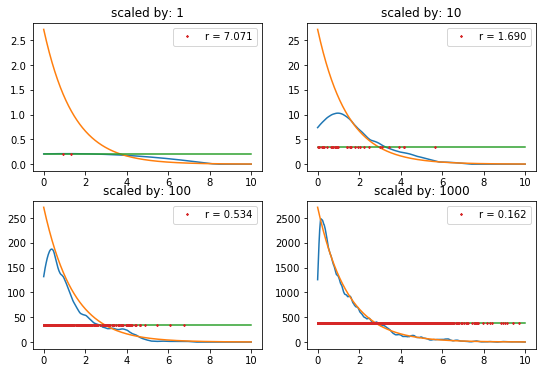

In [39]:
# returns a function with the corrected estimator 
def naive_estimator(data, a, b, radius):
    s= 'lambda x: (' + reduce(add, ['m(0,3.*(1-((%f-x)/(%f))**2)/4)/%f + \\\n' % \
        (data[i], radius, radius) for i in range(len(data))] + ['0.)'])
    # lambda x: sum over i max(0,3.*(1-((c[i]-x)/(r))**2)/4)/r
    return eval(s)

demonstrate_estimator(naive_estimator)

**Introducing the Henrichsen-Szendre Estimator**

As you can see, the limit of the estimated function converges to half of the original function in the naive approach. A simple correction can be made by mirroring the density that spills over past [0, 24] around 0 and 24. 

We have not seen this correction in any of the literature, so we are claiming it as our own.



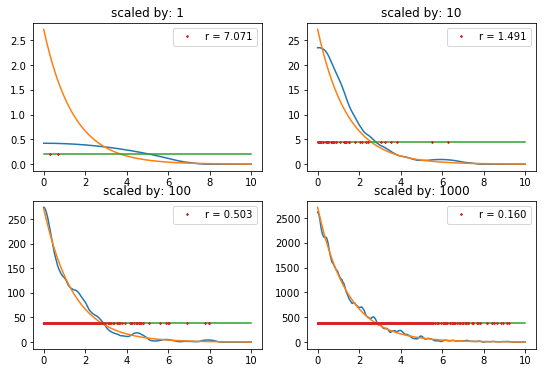

In [40]:
# returns a function with the corrected estimator 
def henrichsen_szendre_estimator(data, a, b, radius):
    s= 'lambda x: (' + reduce(add, ['m(0,3.*(1-((%f-x)/(%f))**2)/4)/%f + \\\n' % \
        (data[i], radius, radius) for i in range(len(data))] + ['0.)'])
    # lambda x: sum over i m(0,3.*(1-((c[i]-x)/(r))**2)/4)/r
    l_naive = eval(s)
    
    def l_reflected(x):
        result = l_naive(x)

        # one sided is fine
        if a <= x <= a+radius:
            result += l_naive(a - (x-a))
        if b-radius <= x <= b:
            result += l_naive(b + (b-x))
        return result

    return l_reflected

demonstrate_estimator(henrichsen_szendre_estimator)

### Sources:


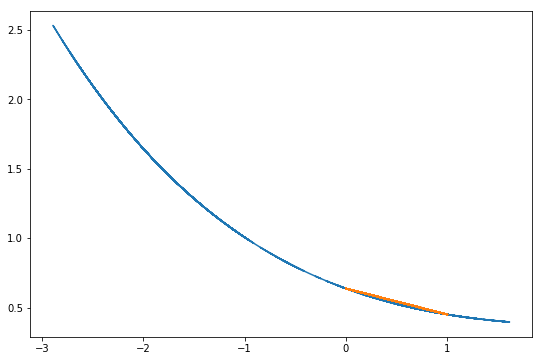

In [43]:

from numpy import polyfit

def time_dependence(x):
    coefficients = np.array([6.37074186e-01,  -2.65604450e-01,   9.01209881e-02, -1.26260653e-02,   9.29554053e-04,  -3.28877874e-05, 4.31316583e-07])
    return np.polynomial.polynomial.polyval(x,coefficients)
plt.rcParams
plt.plot(X, time_dependence(X))
plt.show()
